Use adaboost, Gradient Tree Boosting and xgboosting

# NOTES:
Der er nogle ting du skal tilbage og havde styr på. 

- Du skal have flere variabler med herover den først runde feature selection skal kun være helt grov ect vægle mellem log eller ike log ect.
- Der er pludseligt en helt masse missing i dit y!? wth! får lige styr på den kat..
- i forgående gem df som goepandas.dataframe i pickle
- i forgående gem df (- geometry) som padas.dataframe i csv
- ændre navn fatilities i forgående og lav også en logged version.
- Se generelt din estimation for hvad der giver mening som logged...

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb # objective = 'binary:logistic'
#from sklearn.ensemble import AdaBoostClassifier # But why?
#from sklearn.ensemble import GradientBoostingClassifier #But why?
from sklearn.model_selection import train_test_split

In [2]:

pkl_file = open('chosen_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

In [3]:
#df = df.sample(1000)

In [4]:
df['lead_binary_best'].isna().sum()# the fuck!

64818

In [5]:
df['lead_binary_best'].isna().sum()/df['lead_binary_best'].shape[0]# the fuck!

0.0476194674271911

In [6]:
df.dropna(inplace = True)

In [7]:
df['lead_binary_best'].isna().sum()/df['lead_binary_best'].shape[0]# the fuck!

0.0

In [8]:
df_test = df[df['year']>2005].copy()
df_train = df[df['year']<=2005].copy()
df_train_s = df_train.sample(10000).copy()

# Balanced: 

df_train_1 = df_train[df_train['lead_binary_best'] == 1]
df_train_0 = df_train[df_train['lead_binary_best'] == 0].sample(df_train_1.shape[0])

df_train_ss = pd.concat([df_train_0,df_train_1])

df = df_train_ss.sample(10000)

In [9]:
X = df[['fatilities_country_year', 'log_best', 'log_country_area_sum',
        'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
        'past_conflicts', 'excluded_binary', 'petroleum_full',
        'diff_median_light','binary_best', 'pop_cell_dens', 
        'log_interp_pop_gpw_sum','conflict_country_year']]

y = df['lead_binary_best']

In [10]:
y.sum()/y.shape[0]

0.4988

In [11]:
y.shape

(10000,)

In [12]:
X.shape

(10000, 14)

In [13]:
# Create arrays for the features and the target: X, y
#X, y = churn_data.iloc[:,:-1], churn_data.iloc[:,-1]

# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the classifier to the training set
xg_cl.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_cl.predict_proba(X_test)

# # Compute the accuracy: accuracy
# accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
# print("accuracy: %f" % (accuracy))

In [14]:
from sklearn.metrics import auc, average_precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, precision_score
from sklearn.utils.fixes import signature
# tjek https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [15]:
preds050 = (preds[:,1] >= 0.5)*1 # same as standart recall score!
preds035 = (preds[:,1] >= 0.35)*1
preds020 = (preds[:,1] >= 0.20)*1

In [16]:
# preds01 = xg_cl.predict(X_test)
# recall_score(y_test, preds01)

In [17]:
# Recall precision test:

In [18]:
recall_score(y_test, preds050)

0.9408866995073891

In [19]:
recall_score(y_test, preds035)

0.9645320197044335

In [20]:
recall_score(y_test, preds020)

0.9970443349753695

In [21]:
precision_score(y_test, preds050)

0.9235976789168279

In [22]:
precision_score(y_test, preds035)

0.8883847549909256

In [23]:
precision_score(y_test, preds020)

0.7338651196519217

In [24]:
# plots:

In [25]:
average_precision=average_precision_score(y_test,preds[:,1])

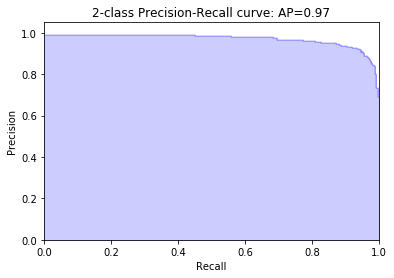

In [26]:
precision, recall, _ = precision_recall_curve(y_test,preds[:,1])


#In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.show()


In [27]:
roc_auc_score(y_test,preds[:,1])

0.9755434972868895

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, preds[:, 1])

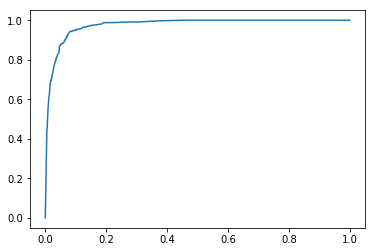

In [29]:
plt.plot(fpr, tpr)
plt.show()

# importance

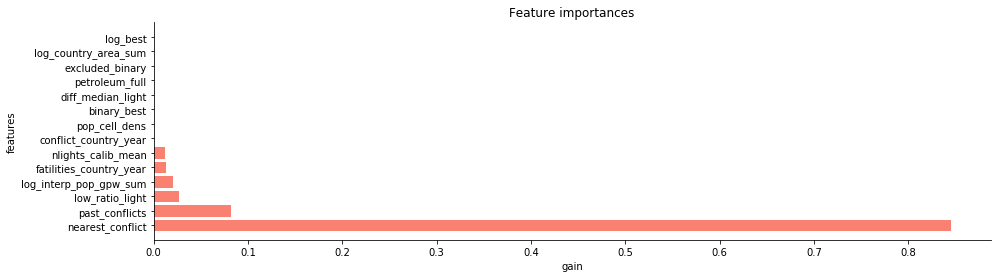

In [30]:
importances = xg_cl.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=[15,int(X.shape[1]/3)])

plt.title("Feature importances")


plt.barh(range(X.shape[1]), importances[indices], color="salmon", align="center")

plt.yticks(range(X.shape[1]),  X.columns[indices])
plt.ylim([-1, X.shape[1]])

plt.xlabel(xg_cl.importance_type)
plt.ylabel('features')

sns.despine()
plt.show()

# OLD SHIT:

In [ ]:
# data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=3, seed=123, silent=False,n_jobs=-1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [ ]:
xg_cl.fit(X_train, y_train, eval_set= [(X_test, y_test)], eval_metric = 'auc', early_stopping_rounds=3,verbose=True)


In [ ]:
print('done')

In [ ]:
xg_cl.fit?

In [ ]:
# # Create arrays for the features and the target: X, y
# X, y = churn_data.iloc[:,:-1], churn_data.iloc[:,-1]

# # Create the training and test sets
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123, silent=False,n_jobs=6)

# Fit the classifier to the training set
xg_cl.fit(X, y)

# # Predict the labels of the test set: preds
# preds = xg_cl.predict(X_test)

# # Compute the accuracy: accuracy
# accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
# print("accuracy: %f" % (accuracy))


In [ ]:
print('done....')

In [ ]:
2

In [ ]:
xgb.XGBClassifier?

In [ ]:
xgb.XGBClassifier().fit

In [ ]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}

In [ ]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123, verbose_eval= True)

In [ ]:
cv_results.head()

In [ ]:
print((cv_results[""]).tail(1))

In [ ]:
np.random.